In [1]:
from dataset.timeseriesToyDataset.timeSeriesDataset import timeSeriesDataset, timeSeriesParameter
from dataset.timeseriesToyDataset.timeSeriesDatasetWithShifts import timeSeriesDatasetWithShifts
from dataset.timeseriesToyDataset.sample_dataset_specification import add_shifts_to_linear_params
from evaluator.visualize import lineplot
import matplotlib.pyplot as plt
from tqdm import tqdm

# LSTM Parameter

In [2]:
windows_size = 20

# dataset preparetion

In [53]:
param = [timeSeriesParameter(0.0000, 10, 0, 10000, 2000, 4), timeSeriesParameter(0.0000, 10, 0, 10000, 2000, 4)]
df  = timeSeriesDatasetWithShifts(add_shifts_to_linear_params(param, windows_size))

In [54]:
df.drop_nulls(subset=f"x_t-{windows_size}")

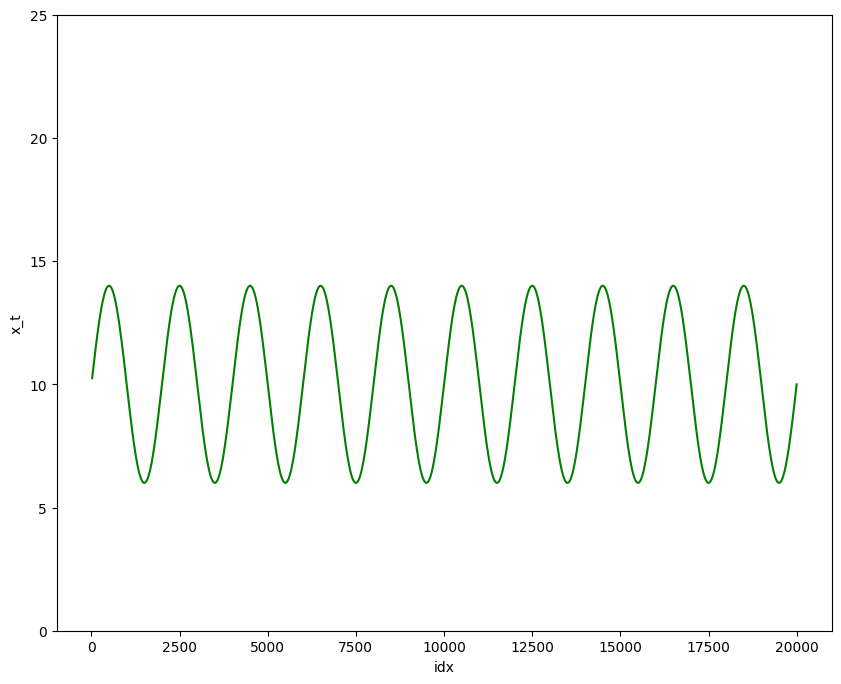

In [55]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_ylim([0, 25])
lineplot(df, "idx", "x_t", hue = None)

In [56]:
import torch
import torch.nn as nn

In [57]:
class LSTM_Torch(nn.Module):
    def __init__(self, input_dim: int, hidden_layer: int, output_size: int):
        super(LSTM_Torch, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_layer, num_layers = 1, batch_first=True)
        self.linear = nn.Linear(hidden_layer, output_size)
        
        nn.init.xavier_normal_(self.lstm.weight_ih_l0)
        nn.init.orthogonal_(self.lstm.weight_hh_l0)

        
    def forward(self, x: torch.Tensor):
        lstm_out, _ = self.lstm(x)
        y_pred = self.linear(lstm_out[:, -1])
        return y_pred


In [58]:
model = LSTM_Torch(windows_size, 10, 1).cuda()
criterion = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [59]:
X_Tensor = torch.from_numpy(df.X.to_numpy()).float().cuda().view(-1, 1, windows_size)
y_Tensor = torch.from_numpy(df.Y.to_numpy()).float().cuda().view(-1)

In [60]:
x = X_Tensor

In [61]:
epochs = 10000

for epoch in tqdm(list(range(epochs))):
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred.view(-1), y_Tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 2000 == 0:
        print(f'Epoch: {epoch+1}, Loss: {loss.item()}')


 21%|██▏       | 2149/10000 [00:02<00:07, 1000.96it/s]

Epoch: 2000, Loss: 0.0397205725312233


 42%|████▏     | 4156/10000 [00:04<00:05, 1000.08it/s]

Epoch: 4000, Loss: 0.006104333326220512


 62%|██████▏   | 6178/10000 [00:06<00:03, 997.38it/s] 

Epoch: 6000, Loss: 0.0009801334235817194


 82%|████████▏ | 8190/10000 [00:08<00:01, 996.71it/s] 

Epoch: 8000, Loss: 0.0004143735859543085


100%|██████████| 10000/10000 [00:09<00:00, 1000.77it/s]

Epoch: 10000, Loss: 0.007940438576042652


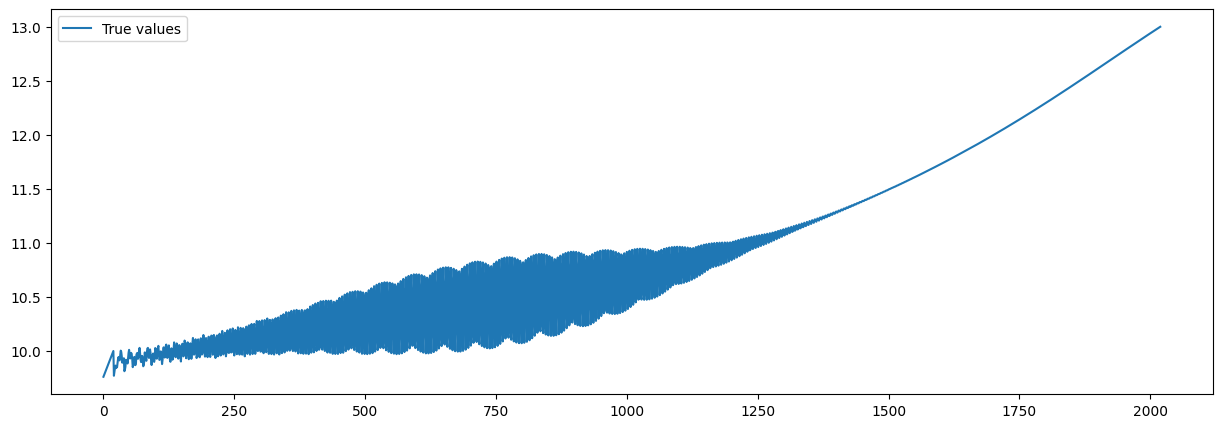

In [62]:
seq_length = 20
test_seq = y_Tensor[-seq_length:].tolist()
for _ in range(2000):
    with torch.no_grad():
        model.eval()
        test_input = torch.tensor(test_seq[-seq_length:]).cuda().float().view(1, 1, seq_length)
        predicted_val = model(test_input).item()
        # print(y_Tensor[-seq_length:],predicted_val)
        test_seq.append(predicted_val)
        # print(test_input, predicted_val)
        
        
        
# サイン波と予測をプロット
plt.figure(figsize=(15,5))
plt.plot(test_seq, label="True values")
plt.legend()
plt.show()